In [3]:
%load_ext autoreload
%autoreload 2
import torch

import os
import sys
module_path = os.path.abspath(os.path.join('../../../src/'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
device = 'cuda' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load models

In [4]:
from classification.models.SpectrogramCNN import SpectrogramCNNPLModule

state_dict_path = '/nfs/students/summer-term-2020/project-4/data/models/SpectrogramBasedCNN.pt'

hparams = {
    "batch_size": 5,
    "learning_rate": 3e-4,
    "weight_decay": 0.001,
    "lr_decay": 0.95
}

model = SpectrogramCNNPLModule(hparams)
model.model.load_state_dict(torch.load(state_dict_path))
model = model.cuda()
model = model.eval()

# Load Data

In [5]:
from datasets.datasethandler import DatasetHandler
datasetHandler = DatasetHandler()

In [10]:
datasetHandler.load(model, 'validation')
datasetHandler.load(model, 'training')

Load: /nfs/students/summer-term-2020/project-4/data/dataset1/dataset_resampled/training.p


# Attacks

In [72]:
epsilons = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]

## Simple PGD

In [ ]:
from attacks.pgd import ProjectedGradientDescent

pgd_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilon': eps, 'num_iter': 50}
    pgd = ProjectedGradientDescent(model, model.val_dataloader(), attack_parameters, save_samples=False)
    pgd.attack()
    pgd_attacks[eps] = pgd

 51%|█████     | 171/338 [04:13<03:56,  1.42s/it]

In [ ]:
for eps in pgd_attacks:
    pgd_attacks[eps].report()
    print()

## Functional Attack: PGD + Volume Attack

In [ ]:
from attacks.functionalVolume import FunctionalVolumeAttack

functional_volume_attacks = {}

for eps in epsilons:
    attack_parameters = {'epsilonVolume': 0.1, 'epsilonPGD': eps, 'num_iter': 50}
    fva = FunctionalVolumeAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_volume_attacks[eps] = fva

In [ ]:
for eps in functional_volume_attacks:
    print(eps)
    functional_volume_attacks[eps].report()
    print()

In [102]:
# functional_attacks[0.0003].showAdversarialExample(target_class=1)

## Functional Interpolation (imperceptible)

In [ ]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [ ]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks_imperceptible = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks_imperceptible[eps] = fva

In [ ]:
for eps in functional_interpolation_attacks_imperceptible:
    functional_interpolation_attacks_imperceptible[eps].report()
    print()

## Functional Interpolation (hearable)

In [ ]:
import random
import IPython.display as ipd

random_sample_index = random.sample(range(len(model.dataset['training'])), 1)[0]
random_sample_index = 2464 # manually picked
random_sample = model.dataset['training'].__getitem__(random_sample_index)

In [ ]:
from attacks.functionalInterpolation import FunctionalInterpolationAttack

functional_interpolation_attacks = {}

for eps in epsilons:
    attack_parameters = {'overlay_sound': random_sample,
                         'epsilonInterpolation': 0.1, 'epsilonNoise': eps, 'num_iter': 50, 
                         'upper2': 1,
                         }
    fva = FunctionalInterpolationAttack(model, model.val_dataloader(), attack_parameters, save_samples=True)
    fva.attack()
    functional_interpolation_attacks[eps] = fva

In [70]:
#ipd.display(ipd.Audio(random_sample['audio'], rate=random_sample['sample_rate']))
#functional_attacks[0.0005].showAdversarialExample(target_class=1)

In [ ]:
for eps in functional_interpolation_attacks:
    functional_interpolation_attacks[eps].report()
    print()

# Visualization

In [81]:
from utils.Visual import draw_plot 

y1 = {'data': [pgd_attacks[attack_id].getSuccessRate() for attack_id in pgd_attacks]}
y1['color'] = 'b'
y1['label'] = "Adding noise"

y2 = {'data': [functional_attacks[attack_id].getSuccessRate() for attack_id in functional_attacks]}
y2['color'] = 'r'
y2['label'] = "Adding noise + Changing Volume"

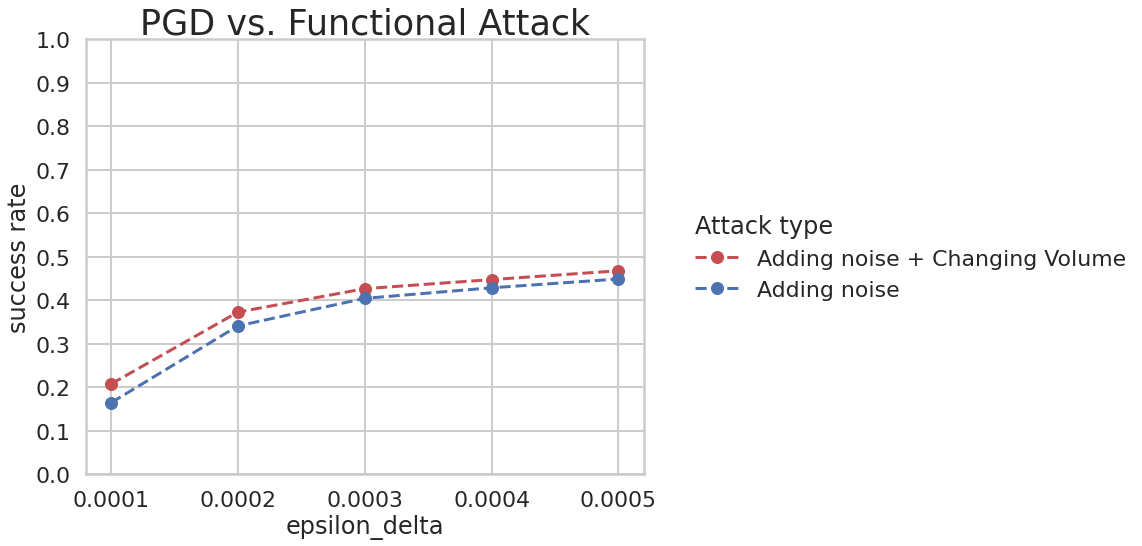

In [87]:
draw_plot(epsilons, data = [y2, y1], legend_x_offset=1.9, title="PGD vs. Functional Attacks",
          legend_title="Attack type", x_label="epsilon_delta", y_label="success rate")